##Add image augmentation

This notebook is to create a folder with augmented images of the same structure as the stage1_train.

The augmentation is generated by imgaug python library.



In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
from imgaug import augmenters as iaa
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

from config import Config
import utils
import model as modellib
import visualize
import skimage.color
import skimage.io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from model import log


%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
#if not os.path.exists(COCO_MODEL_PATH):
#    utils.download_trained_weights(COCO_MODEL_PATH)

D:\Anaconda3\envs\kaggle\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


In [ ]:
## Yizhen's path
TRAIN_PATH = './kaggle-dsbowl-2018-dataset-fixes-master/stage1_train/'
TEST_PATH = './input/stage1_test/'
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
## Yinan's path
TRAIN_PATH = './input/stage1_train/' ## This is the fixed version.
TEST_PATH = './input/stage1_test/'
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
#create the nuclei dataset

class NucleiDataset(utils.Dataset):
    
    def load_nuclei(self, path, ids):       
        #Add class
        self.add_class("nuclei", 1, "nuclei")

        # Add image
        for i in range(len(ids)):
            path_image = path + ids[i] + '/images/' + ids[i] + '.png'
            mask_path = path + ids[i] + '/masks/'
            self.add_image("nuclei", image_id=i, path=path_image, maskpath=mask_path)
     
     
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])[:, :, :3]
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image       
  
         
    def load_mask(self, i):
        img = self.load_image(i)
        width = img.shape[1]
        height = img.shape[0]
        n = len(next(os.walk(self.image_info[i]['maskpath']))[2])       
        mask = np.zeros((height, width, n), dtype=np.bool)
        for t, mask_file in enumerate(next(os.walk(self.image_info[i]['maskpath']))[2]):            
            mask_ = imread(self.image_info[i]['maskpath'] + mask_file)
            mask[:, :, t:t+1] = np.reshape(mask_,(height,width,1))
        class_ids = np.array([1]*n)
        return mask, class_ids
        

In [5]:

category = './input/classes.csv'
cate = pd.read_csv(category,index_col=False)
#print((cate['foreground'] == 'white') & (cate['background'] == 'black')) 
white_black = cate.loc[(cate['foreground'] == 'white') \
                       & (cate['background'] == 'black'),'filename'].tolist()
purple_yellow = cate.loc[(cate['foreground'] == 'purple') \
                       & (cate['background'] == 'yellow') ,'filename'].tolist()
purple_white = cate.loc[(cate['foreground'] == 'purple') \
                       & (cate['background'] == 'white') ,'filename'].tolist()
purple_purple = cate.loc[(cate['foreground'] == 'purple') \
                       & (cate['background'] == 'purple') ,'filename'].tolist()
black_white = cate.loc[(cate['foreground'] == 'black') \
                       & (cate['background'] == 'white') ,'filename'].tolist()

print("number of white_black image: %d" %len(white_black))
print("number of purple_yellow image: %d" %len(purple_yellow))
print("number of purple_white image: %d" %len(purple_white))
print("number of purple_purple image: %d" %len(purple_purple))
print("number of black_white image: %d" %len(black_white))


number of white_black image: 599
number of purple_yellow image: 8
number of purple_white image: 41
number of purple_purple image: 71
number of black_white image: 16


In [6]:
train_index = [n for i, n in enumerate(train_ids) \
               if n+".png" in white_black[:int(len(white_black)*0.8)]]
val_index = [n for i, n in enumerate(train_ids) \
             if n+".png" in white_black[int(len(white_black)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in purple_yellow[:int(len(purple_yellow)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in purple_yellow[int(len(purple_yellow)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in purple_white[:int(len(purple_white)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in purple_white[int(len(purple_white)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in purple_purple[:int(len(purple_purple)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in purple_purple[int(len(purple_purple)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in black_white[:int(len(black_white)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in black_white[int(len(black_white)*0.8):]]
print("length of train set: %d" %len(train_index))
print("length of validation set: %d" %len(val_index))
print(bool(set(val_index) & set(train_index)))

length of train set: 531
length of validation set: 133
False


In [15]:
# Training dataset
dataset_train = NucleiDataset()
dataset_train.load_nuclei(TRAIN_PATH, train_index)
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(TRAIN_PATH, val_index) 
dataset_val.prepare()

###Create sequential image augmentation pipeline.

Can also use iaa.SomeOf, OneOf, Sometimes to add randomness to the image augmentation pipeline (see the API).

In [8]:
import imgaug as ia
from imgaug import augmenters as iaa
import shutil

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.8, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.
seq = iaa.Sequential(
    [
        # Note: Somehow crop cannot be applied to mask. 
        # Same for other transform like PerspectiveTransform...
        
        # apply the following augmenters to most images
        iaa.Fliplr(0.8),  # horizontally flip 80% of all images
        iaa.Flipud(0.8),  # vertically flip 90% of all images

        iaa.Affine(
            scale={"x": (0.7, 1.3), "y": (0.7, 1.3)},  # scale images to 70-130% of their size, individually per axis
            translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)},  # translate by -30 to +30 percent (per axis)
            rotate=(-45, 45),  # rotate by -45 to +45 degrees
            shear=(-45, 45),  # shear by -45 to +45 degrees
            order=[0, 1],  # use nearest neighbour or bilinear interpolation (fast)
            cval=0, # use black to fill up
            mode='constant'  # use black to fill up
        ),
        
        # execute 1 to 3 of the following augmenters per image
        # mask will skip these augmentation
        iaa.SomeOf((1, 3), [
                iaa.OneOf([
                    iaa.GaussianBlur((0.5, 2)),  # blur images with a sigma between 0.5 and 2
                    iaa.AverageBlur(k=(2, 5)),  # blur image using local means with kernel sizes between 2 and 5
                    iaa.MedianBlur(k=(3, 5)),  # blur image using local medians with kernel sizes between 3 and 5
                ]),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=False),   # add gaussian noise to images
                iaa.Add((-10, 10), per_channel=False),  # change brightness of images (by -10 to 10 of original value)
                iaa.ContrastNormalization((0.8, 1.2), per_channel=False),  # improve or worsen the contrast
            ], random_order=True, name="AdvancedAug")
    ], random_order=True
)


Create a folder to store the augmented images

In [14]:
# Dynamically disable color augmentations on masks- don't apply advanced augmentation to mask
def activator_masks(images, augmenter, parents, default):
    if augmenter.name in ["AdvancedAug"]:
        return False
    else:
        # default value for all other augmenters
        return default
    
    
hooks_masks = ia.HooksImages(activator=activator_masks)


# Generate augmentations and save
def save_aug(image_id, index, dataset, batch_name):
    
    root_path = "./input/" + batch_name + "/"
    if not os.path.exists(root_path):
        os.mkdir(root_path)
    
    fig_name = index[image_id]
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)

    image_aug_root_path = root_path + fig_name
    image_aug_path = image_aug_root_path + "/images/"
    mask_aug_path = image_aug_root_path + "/masks/"
    
    # if the image root folder exist, delete it and make a new one (i.e. overwirte)
    if os.path.exists(image_aug_root_path):
        shutil.rmtree(image_aug_root_path)
    os.mkdir(image_aug_root_path)
    os.mkdir(image_aug_path) 
    os.mkdir(mask_aug_path) 

    # Augment image and save
    image_file_path = image_aug_path + fig_name + ".png"
    images_aug = seq_det.augment_image(image)
    skimage.io.imsave(image_file_path, images_aug)
    
    # Augment masks and save
    mask_path = mask_aug_path + fig_name
    for i in range(mask.shape[2]):        
        mask_aug = seq_det.augment_image(mask[:,:,i], hooks=hooks_masks).astype(int)
        if mask_aug.sum() != 0: # if this slice does not have positive mask, ignore this slice
            mask_aug[np.where(mask_aug==1)] = 255
            skimage.io.imsave(mask_path + str(i) + ".png", mask_aug)
        else:
            continue

Here only tested one image from the stage1_train folder, can use a loop to create augmented image for each image in this folder.

In [220]:

# every time you run this, the seq will be updated and then fixed.
# seq_det = seq.to_deterministic()


In [10]:
import warnings #too much warnings about saving low contrast images
from tqdm import tqdm

warnings.filterwarnings('ignore')


# START AUGMENTATION! 
batch_name = 'AugBatch1'

print(batch_name)

AugBatch1

In [17]:
# Test the first 10 image
#N_TRAIN = 10

# Augment train set
N_TRAIN = len(train_index)

for id in tqdm(range(N_TRAIN)):
    seq_det = seq.to_deterministic()
    save_aug(id, train_index, dataset_train, batch_name) 

  0%|          | 0/531 [00:00<?, ?it/s]

  0%|          | 1/531 [00:00<02:22,  3.73it/s]

  0%|          | 2/531 [00:00<02:21,  3.73it/s]

  1%|          | 3/531 [00:00<02:24,  3.65it/s]

  1%|          | 4/531 [00:01<02:15,  3.89it/s]

  1%|          | 5/531 [00:01<02:42,  3.24it/s]

  1%|          | 6/531 [00:01<02:39,  3.30it/s]

  1%|▏         | 7/531 [00:03<03:59,  2.18it/s]

  2%|▏         | 8/531 [00:03<04:16,  2.04it/s]

  2%|▏         | 9/531 [00:04<04:06,  2.12it/s]

  2%|▏         | 10/531 [00:04<03:51,  2.25it/s]

  2%|▏         | 11/531 [00:05<04:07,  2.10it/s]

  2%|▏         | 13/531 [00:05<03:34,  2.41it/s]

  3%|▎         | 14/531 [00:05<03:22,  2.55it/s]

  3%|▎         | 15/531 [00:15<08:54,  1.04s/it]

  3%|▎         | 17/531 [00:16<08:06,  1.06it/s]

  3%|▎         | 18/531 [00:16<07:47,  1.10it/s]

  4%|▎         | 19/531 [00:16<07:25,  1.15it/s]

  4%|▍         | 20/531 [00:17<07:14,  1.18it/s]

  4%|▍         | 22/531 [00:17<06:47,  1.25it/s]

  4%|▍         | 23/531 [00:18<06:45,  1.25it/s]

  5%|▍         | 24/531 [00:18<06:33,  1.29it/s]

  5%|▍         | 25/531 [00:19<06:25,  1.31it/s]

  5%|▍         | 26/531 [00:19<06:18,  1.33it/s]

  5%|▌         | 27/531 [00:19<06:08,  1.37it/s]

  5%|▌         | 28/531 [00:30<09:14,  1.10s/it]

  5%|▌         | 29/531 [00:31<09:01,  1.08s/it]

  6%|▌         | 30/531 [00:31<08:45,  1.05s/it]

  6%|▌         | 31/531 [00:33<08:56,  1.07s/it]

  6%|▌         | 33/531 [00:33<08:24,  1.01s/it]

  6%|▋         | 34/531 [00:34<08:20,  1.01s/it]

  7%|▋         | 35/531 [00:34<08:09,  1.01it/s]

  7%|▋         | 36/531 [00:41<09:27,  1.15s/it]

  7%|▋         | 37/531 [00:41<09:17,  1.13s/it]

  7%|▋         | 38/531 [00:41<09:03,  1.10s/it]

  8%|▊         | 40/531 [00:46<09:33,  1.17s/it]

  8%|▊         | 41/531 [00:47<09:23,  1.15s/it]

  8%|▊         | 42/531 [00:47<09:10,  1.13s/it]

  8%|▊         | 43/531 [00:50<09:38,  1.18s/it]

  8%|▊         | 44/531 [00:51<09:29,  1.17s/it]

  8%|▊         | 45/531 [00:51<09:21,  1.15s/it]

  9%|▊         | 46/531 [00:52<09:09,  1.13s/it]

  9%|▉         | 47/531 [00:58<10:07,  1.25s/it]

  9%|▉         | 48/531 [00:59<09:56,  1.23s/it]

  9%|▉         | 49/531 [00:59<09:43,  1.21s/it]

 10%|▉         | 51/531 [00:59<09:21,  1.17s/it]

 10%|▉         | 52/531 [00:59<09:10,  1.15s/it]

 10%|▉         | 53/531 [01:00<09:01,  1.13s/it]

 10%|█         | 54/531 [01:04<09:33,  1.20s/it]

 10%|█         | 55/531 [01:05<09:29,  1.20s/it]

 11%|█         | 56/531 [01:06<09:20,  1.18s/it]

 11%|█         | 57/531 [01:25<11:50,  1.50s/it]

 11%|█         | 58/531 [01:26<11:46,  1.49s/it]

 11%|█         | 59/531 [01:29<11:57,  1.52s/it]

 11%|█▏        | 60/531 [01:29<11:45,  1.50s/it]

 12%|█▏        | 62/531 [01:30<11:25,  1.46s/it]

 12%|█▏        | 63/531 [01:30<11:13,  1.44s/it]

 12%|█▏        | 65/531 [01:31<10:53,  1.40s/it]

 12%|█▏        | 66/531 [01:31<10:45,  1.39s/it]

 13%|█▎        | 67/531 [01:31<10:36,  1.37s/it]

 13%|█▎        | 68/531 [01:32<10:27,  1.35s/it]

 13%|█▎        | 69/531 [01:32<10:18,  1.34s/it]

 13%|█▎        | 70/531 [01:32<10:11,  1.33s/it]

 13%|█▎        | 71/531 [01:33<10:02,  1.31s/it]

 14%|█▎        | 72/531 [01:33<09:55,  1.30s/it]

 14%|█▎        | 73/531 [01:33<09:49,  1.29s/it]

 14%|█▍        | 74/531 [01:34<09:42,  1.27s/it]

 14%|█▍        | 75/531 [01:34<09:34,  1.26s/it]

 14%|█▍        | 76/531 [01:34<09:25,  1.24s/it]

 15%|█▍        | 77/531 [01:34<09:19,  1.23s/it]

 15%|█▍        | 78/531 [01:35<09:15,  1.23s/it]

 15%|█▍        | 79/531 [01:35<09:09,  1.21s/it]

 15%|█▌        | 80/531 [01:42<09:38,  1.28s/it]

 15%|█▌        | 81/531 [01:42<09:30,  1.27s/it]

 15%|█▌        | 82/531 [01:43<09:25,  1.26s/it]

 16%|█▌        | 83/531 [01:43<09:21,  1.25s/it]

 16%|█▌        | 84/531 [01:44<09:14,  1.24s/it]

 16%|█▌        | 85/531 [01:44<09:10,  1.23s/it]

 16%|█▌        | 86/531 [01:45<09:05,  1.23s/it]

 16%|█▋        | 87/531 [01:45<08:59,  1.21s/it]

 17%|█▋        | 88/531 [01:46<08:56,  1.21s/it]

 17%|█▋        | 90/531 [01:46<08:43,  1.19s/it]

 17%|█▋        | 91/531 [01:47<08:38,  1.18s/it]

 17%|█▋        | 92/531 [01:47<08:32,  1.17s/it]

 18%|█▊        | 93/531 [01:47<08:26,  1.16s/it]

 18%|█▊        | 94/531 [01:48<08:22,  1.15s/it]

 18%|█▊        | 95/531 [01:48<08:16,  1.14s/it]

 18%|█▊        | 96/531 [01:54<08:37,  1.19s/it]

 18%|█▊        | 97/531 [01:54<08:33,  1.18s/it]

 18%|█▊        | 98/531 [01:55<08:29,  1.18s/it]

 19%|█▊        | 99/531 [01:55<08:24,  1.17s/it]

 19%|█▉        | 100/531 [01:55<08:18,  1.16s/it]

 19%|█▉        | 101/531 [01:56<08:15,  1.15s/it]

 19%|█▉        | 102/531 [01:56<08:10,  1.14s/it]

 19%|█▉        | 103/531 [01:57<08:06,  1.14s/it]

 20%|█▉        | 104/531 [01:57<08:03,  1.13s/it]

 20%|█▉        | 105/531 [01:58<07:58,  1.12s/it]

 20%|█▉        | 106/531 [01:58<07:55,  1.12s/it]

 20%|██        | 107/531 [01:59<07:52,  1.11s/it]

 20%|██        | 108/531 [01:59<07:48,  1.11s/it]

 21%|██        | 109/531 [02:00<07:47,  1.11s/it]

 21%|██        | 110/531 [02:00<07:42,  1.10s/it]

 21%|██        | 111/531 [02:01<07:38,  1.09s/it]

 21%|██        | 112/531 [02:01<07:35,  1.09s/it]

 21%|██▏       | 113/531 [02:02<07:32,  1.08s/it]

 21%|██▏       | 114/531 [02:04<07:34,  1.09s/it]

 22%|██▏       | 115/531 [02:05<07:33,  1.09s/it]

 22%|██▏       | 116/531 [02:05<07:30,  1.09s/it]

 22%|██▏       | 117/531 [02:06<07:26,  1.08s/it]

 22%|██▏       | 118/531 [02:12<07:44,  1.12s/it]

 22%|██▏       | 119/531 [02:12<07:40,  1.12s/it]

 23%|██▎       | 120/531 [02:13<07:35,  1.11s/it]

 23%|██▎       | 121/531 [02:13<07:31,  1.10s/it]

 23%|██▎       | 122/531 [02:13<07:27,  1.09s/it]

 23%|██▎       | 123/531 [02:13<07:23,  1.09s/it]

 23%|██▎       | 124/531 [02:15<07:26,  1.10s/it]

 24%|██▎       | 125/531 [02:16<07:22,  1.09s/it]

 24%|██▎       | 126/531 [02:16<07:18,  1.08s/it]

 24%|██▍       | 127/531 [02:16<07:14,  1.08s/it]

 24%|██▍       | 128/531 [02:17<07:11,  1.07s/it]

 24%|██▍       | 129/531 [02:17<07:08,  1.07s/it]

 24%|██▍       | 130/531 [02:24<07:25,  1.11s/it]

 25%|██▍       | 131/531 [02:24<07:21,  1.10s/it]

 25%|██▍       | 132/531 [02:34<07:45,  1.17s/it]

 25%|██▌       | 133/531 [02:36<07:48,  1.18s/it]

 25%|██▌       | 134/531 [02:36<07:44,  1.17s/it]

 25%|██▌       | 135/531 [02:37<07:41,  1.16s/it]

 26%|██▌       | 136/531 [02:37<07:38,  1.16s/it]

 26%|██▌       | 137/531 [02:38<07:34,  1.15s/it]

 26%|██▌       | 138/531 [02:59<08:30,  1.30s/it]

 26%|██▌       | 139/531 [03:06<08:45,  1.34s/it]

 27%|██▋       | 141/531 [03:14<08:56,  1.38s/it]

 27%|██▋       | 142/531 [03:14<08:53,  1.37s/it]

 27%|██▋       | 143/531 [03:15<08:50,  1.37s/it]

 27%|██▋       | 144/531 [03:15<08:46,  1.36s/it]

 27%|██▋       | 145/531 [03:15<08:41,  1.35s/it]

 27%|██▋       | 146/531 [03:16<08:38,  1.35s/it]

 28%|██▊       | 147/531 [03:17<08:34,  1.34s/it]

 28%|██▊       | 148/531 [03:17<08:30,  1.33s/it]

 28%|██▊       | 149/531 [03:17<08:25,  1.32s/it]

 28%|██▊       | 150/531 [03:17<08:22,  1.32s/it]

 28%|██▊       | 151/531 [03:18<08:19,  1.31s/it]

 29%|██▉       | 153/531 [03:18<08:11,  1.30s/it]

 29%|██▉       | 154/531 [03:19<08:07,  1.29s/it]

 29%|██▉       | 155/531 [03:19<08:04,  1.29s/it]

 29%|██▉       | 156/531 [03:19<07:59,  1.28s/it]

 30%|██▉       | 157/531 [03:19<07:55,  1.27s/it]

 30%|██▉       | 158/531 [03:20<07:52,  1.27s/it]

 30%|██▉       | 159/531 [03:20<07:49,  1.26s/it]

 30%|███       | 160/531 [03:22<07:49,  1.27s/it]

 30%|███       | 161/531 [03:22<07:46,  1.26s/it]

 31%|███       | 162/531 [03:23<07:43,  1.26s/it]

 31%|███       | 163/531 [03:23<07:39,  1.25s/it]

 31%|███       | 164/531 [03:24<07:38,  1.25s/it]

 31%|███       | 165/531 [03:25<07:35,  1.24s/it]

 31%|███▏      | 166/531 [03:25<07:31,  1.24s/it]

 31%|███▏      | 167/531 [03:29<07:37,  1.26s/it]

 32%|███▏      | 168/531 [03:30<07:35,  1.25s/it]

 32%|███▏      | 169/531 [03:30<07:31,  1.25s/it]

 32%|███▏      | 170/531 [03:31<07:28,  1.24s/it]

 32%|███▏      | 171/531 [03:31<07:24,  1.24s/it]

 32%|███▏      | 172/531 [03:31<07:22,  1.23s/it]

 33%|███▎      | 173/531 [03:32<07:18,  1.23s/it]

 33%|███▎      | 174/531 [03:32<07:15,  1.22s/it]

 33%|███▎      | 175/531 [03:32<07:12,  1.22s/it]

 33%|███▎      | 176/531 [03:33<07:10,  1.21s/it]

 33%|███▎      | 177/531 [03:33<07:07,  1.21s/it]

 34%|███▎      | 178/531 [03:33<07:04,  1.20s/it]

 34%|███▎      | 179/531 [03:34<07:01,  1.20s/it]

 34%|███▍      | 180/531 [03:34<06:58,  1.19s/it]

 34%|███▍      | 181/531 [03:34<06:55,  1.19s/it]

 34%|███▍      | 182/531 [03:40<07:02,  1.21s/it]

 34%|███▍      | 183/531 [03:43<07:05,  1.22s/it]

 35%|███▍      | 184/531 [03:44<07:02,  1.22s/it]

 35%|███▍      | 185/531 [03:44<07:00,  1.21s/it]

 35%|███▌      | 186/531 [03:44<06:57,  1.21s/it]

 35%|███▌      | 187/531 [03:45<06:53,  1.20s/it]

 35%|███▌      | 188/531 [03:45<06:50,  1.20s/it]

 36%|███▌      | 189/531 [03:46<06:48,  1.20s/it]

 36%|███▌      | 190/531 [03:46<06:45,  1.19s/it]

 36%|███▌      | 191/531 [03:46<06:43,  1.19s/it]

 36%|███▌      | 192/531 [03:57<06:59,  1.24s/it]

 36%|███▋      | 193/531 [03:57<06:56,  1.23s/it]

 37%|███▋      | 194/531 [03:58<06:54,  1.23s/it]

 37%|███▋      | 195/531 [03:58<06:51,  1.22s/it]

 37%|███▋      | 196/531 [03:59<06:48,  1.22s/it]

 37%|███▋      | 197/531 [03:59<06:45,  1.21s/it]

 37%|███▋      | 198/531 [03:59<06:42,  1.21s/it]

 37%|███▋      | 199/531 [04:03<06:45,  1.22s/it]

 38%|███▊      | 200/531 [04:04<06:43,  1.22s/it]

 38%|███▊      | 201/531 [04:04<06:41,  1.22s/it]

 38%|███▊      | 202/531 [04:04<06:38,  1.21s/it]

 38%|███▊      | 203/531 [04:05<06:36,  1.21s/it]

 38%|███▊      | 204/531 [04:06<06:34,  1.21s/it]

 39%|███▊      | 205/531 [04:06<06:32,  1.20s/it]

 39%|███▉      | 207/531 [04:07<06:26,  1.19s/it]

 39%|███▉      | 208/531 [04:07<06:24,  1.19s/it]

 39%|███▉      | 209/531 [04:07<06:21,  1.19s/it]

 40%|███▉      | 210/531 [04:08<06:19,  1.18s/it]

 40%|███▉      | 211/531 [04:09<06:17,  1.18s/it]

 40%|███▉      | 212/531 [04:09<06:15,  1.18s/it]

 40%|████      | 213/531 [04:13<06:18,  1.19s/it]

 40%|████      | 214/531 [04:14<06:16,  1.19s/it]

 40%|████      | 215/531 [04:15<06:15,  1.19s/it]

 41%|████      | 216/531 [04:15<06:12,  1.18s/it]

 41%|████      | 217/531 [04:15<06:10,  1.18s/it]

 41%|████      | 219/531 [04:16<06:05,  1.17s/it]

 41%|████▏     | 220/531 [04:20<06:07,  1.18s/it]

 42%|████▏     | 221/531 [04:20<06:05,  1.18s/it]

 42%|████▏     | 222/531 [04:20<06:03,  1.18s/it]

 42%|████▏     | 223/531 [04:21<06:00,  1.17s/it]

 42%|████▏     | 224/531 [04:21<05:58,  1.17s/it]

 43%|████▎     | 226/531 [04:21<05:52,  1.16s/it]

 43%|████▎     | 228/531 [04:21<05:48,  1.15s/it]

 43%|████▎     | 229/531 [04:23<05:47,  1.15s/it]

 43%|████▎     | 230/531 [04:27<05:50,  1.16s/it]

 44%|████▎     | 231/531 [04:29<05:49,  1.16s/it]

 44%|████▎     | 232/531 [04:29<05:47,  1.16s/it]

 44%|████▍     | 233/531 [04:29<05:44,  1.16s/it]

 44%|████▍     | 234/531 [04:29<05:42,  1.15s/it]

 44%|████▍     | 236/531 [04:43<05:54,  1.20s/it]

 45%|████▍     | 237/531 [04:43<05:51,  1.20s/it]

 45%|████▍     | 238/531 [04:43<05:49,  1.19s/it]

 45%|████▌     | 239/531 [04:44<05:47,  1.19s/it]

 45%|████▌     | 240/531 [04:44<05:44,  1.19s/it]

 45%|████▌     | 241/531 [04:44<05:42,  1.18s/it]

 46%|████▌     | 242/531 [04:45<05:40,  1.18s/it]

 46%|████▌     | 244/531 [04:45<05:35,  1.17s/it]

 46%|████▌     | 245/531 [04:45<05:33,  1.17s/it]

 47%|████▋     | 247/531 [04:47<05:30,  1.16s/it]

 47%|████▋     | 248/531 [04:56<05:37,  1.19s/it]

 47%|████▋     | 249/531 [04:56<05:35,  1.19s/it]

 47%|████▋     | 250/531 [05:02<05:39,  1.21s/it]

 47%|████▋     | 251/531 [05:02<05:37,  1.20s/it]

 47%|████▋     | 252/531 [05:02<05:35,  1.20s/it]

 48%|████▊     | 253/531 [05:06<05:36,  1.21s/it]

 48%|████▊     | 254/531 [05:06<05:34,  1.21s/it]

 48%|████▊     | 255/531 [05:06<05:32,  1.20s/it]

 48%|████▊     | 256/531 [05:06<05:29,  1.20s/it]

 48%|████▊     | 257/531 [05:07<05:27,  1.20s/it]

 49%|████▊     | 258/531 [05:07<05:25,  1.19s/it]

 49%|████▉     | 259/531 [05:08<05:23,  1.19s/it]

 49%|████▉     | 260/531 [05:08<05:21,  1.19s/it]

 49%|████▉     | 261/531 [05:08<05:19,  1.18s/it]

 49%|████▉     | 262/531 [05:09<05:17,  1.18s/it]

 50%|████▉     | 263/531 [05:09<05:15,  1.18s/it]

 50%|████▉     | 264/531 [05:10<05:13,  1.17s/it]

 50%|████▉     | 265/531 [05:12<05:13,  1.18s/it]

 50%|█████     | 266/531 [05:12<05:11,  1.18s/it]

 50%|█████     | 267/531 [05:12<05:09,  1.17s/it]

 50%|█████     | 268/531 [05:32<05:26,  1.24s/it]

 51%|█████     | 269/531 [05:33<05:24,  1.24s/it]

 51%|█████     | 270/531 [05:33<05:22,  1.23s/it]

 51%|█████     | 271/531 [05:33<05:20,  1.23s/it]

 51%|█████     | 272/531 [05:33<05:17,  1.23s/it]

 51%|█████▏    | 273/531 [05:34<05:15,  1.22s/it]

 52%|█████▏    | 274/531 [05:35<05:15,  1.23s/it]

 52%|█████▏    | 275/531 [05:36<05:12,  1.22s/it]

 52%|█████▏    | 276/531 [05:36<05:10,  1.22s/it]

 52%|█████▏    | 277/531 [05:36<05:08,  1.21s/it]

 52%|█████▏    | 278/531 [05:36<05:06,  1.21s/it]

 53%|█████▎    | 279/531 [05:43<05:10,  1.23s/it]

 53%|█████▎    | 280/531 [05:43<05:07,  1.23s/it]

 53%|█████▎    | 281/531 [05:50<05:12,  1.25s/it]

 53%|█████▎    | 282/531 [05:51<05:10,  1.25s/it]

 53%|█████▎    | 283/531 [05:51<05:08,  1.24s/it]

 53%|█████▎    | 284/531 [05:52<05:06,  1.24s/it]

 54%|█████▎    | 285/531 [05:52<05:03,  1.24s/it]

 54%|█████▍    | 286/531 [05:57<05:06,  1.25s/it]

 54%|█████▍    | 287/531 [05:58<05:04,  1.25s/it]

 54%|█████▍    | 288/531 [05:58<05:02,  1.24s/it]

 54%|█████▍    | 289/531 [05:59<05:00,  1.24s/it]

 55%|█████▍    | 290/531 [05:59<04:58,  1.24s/it]

 55%|█████▍    | 291/531 [06:00<04:57,  1.24s/it]

 55%|█████▍    | 292/531 [06:00<04:54,  1.23s/it]

 55%|█████▌    | 293/531 [06:00<04:52,  1.23s/it]

 55%|█████▌    | 294/531 [06:01<04:51,  1.23s/it]

 56%|█████▌    | 295/531 [06:01<04:49,  1.23s/it]

 56%|█████▌    | 296/531 [06:01<04:47,  1.22s/it]

 56%|█████▌    | 297/531 [06:03<04:46,  1.22s/it]

 56%|█████▌    | 298/531 [06:03<04:44,  1.22s/it]

 56%|█████▋    | 299/531 [06:03<04:42,  1.22s/it]

 56%|█████▋    | 300/531 [06:04<04:40,  1.22s/it]

 57%|█████▋    | 301/531 [06:04<04:38,  1.21s/it]

 57%|█████▋    | 302/531 [06:04<04:36,  1.21s/it]

 57%|█████▋    | 303/531 [06:05<04:34,  1.21s/it]

 57%|█████▋    | 304/531 [06:05<04:32,  1.20s/it]

 57%|█████▋    | 305/531 [06:14<04:37,  1.23s/it]

 58%|█████▊    | 306/531 [06:14<04:35,  1.22s/it]

 58%|█████▊    | 307/531 [06:14<04:33,  1.22s/it]

 58%|█████▊    | 308/531 [06:15<04:31,  1.22s/it]

 58%|█████▊    | 309/531 [06:18<04:31,  1.22s/it]

 59%|█████▊    | 311/531 [06:18<04:28,  1.22s/it]

 59%|█████▉    | 312/531 [06:19<04:26,  1.22s/it]

 59%|█████▉    | 313/531 [06:19<04:24,  1.21s/it]

 59%|█████▉    | 314/531 [06:25<04:26,  1.23s/it]

 59%|█████▉    | 315/531 [06:25<04:24,  1.23s/it]

 60%|█████▉    | 316/531 [06:26<04:22,  1.22s/it]

 60%|█████▉    | 317/531 [06:32<04:24,  1.24s/it]

 60%|█████▉    | 318/531 [06:32<04:22,  1.23s/it]

 60%|██████    | 319/531 [06:32<04:21,  1.23s/it]

 60%|██████    | 320/531 [06:33<04:19,  1.23s/it]

 60%|██████    | 321/531 [06:33<04:17,  1.23s/it]

 61%|██████    | 322/531 [06:34<04:15,  1.22s/it]

 61%|██████    | 323/531 [06:34<04:13,  1.22s/it]

 61%|██████    | 324/531 [06:34<04:11,  1.22s/it]

 61%|██████    | 325/531 [06:34<04:10,  1.21s/it]

 61%|██████▏   | 326/531 [06:35<04:08,  1.21s/it]

 62%|██████▏   | 327/531 [06:35<04:07,  1.21s/it]

 62%|██████▏   | 328/531 [06:36<04:05,  1.21s/it]

 62%|██████▏   | 329/531 [06:36<04:03,  1.21s/it]

 62%|██████▏   | 330/531 [06:37<04:01,  1.20s/it]

 62%|██████▏   | 331/531 [06:37<04:00,  1.20s/it]

 63%|██████▎   | 332/531 [06:38<03:58,  1.20s/it]

 63%|██████▎   | 333/531 [06:38<03:56,  1.20s/it]

 63%|██████▎   | 334/531 [06:39<03:55,  1.19s/it]

 63%|██████▎   | 335/531 [06:39<03:53,  1.19s/it]

 63%|██████▎   | 336/531 [06:41<03:53,  1.20s/it]

 63%|██████▎   | 337/531 [06:41<03:51,  1.19s/it]

 64%|██████▎   | 338/531 [06:58<03:59,  1.24s/it]

 64%|██████▍   | 339/531 [07:06<04:01,  1.26s/it]

 64%|██████▍   | 340/531 [07:06<03:59,  1.25s/it]

 64%|██████▍   | 342/531 [07:06<03:55,  1.25s/it]

 65%|██████▍   | 343/531 [07:07<03:54,  1.25s/it]

 65%|██████▍   | 344/531 [07:07<03:52,  1.24s/it]

 65%|██████▍   | 345/531 [07:08<03:50,  1.24s/it]

 65%|██████▌   | 346/531 [07:08<03:48,  1.24s/it]

 65%|██████▌   | 347/531 [07:08<03:47,  1.23s/it]

 66%|██████▌   | 348/531 [07:08<03:45,  1.23s/it]

 66%|██████▌   | 349/531 [07:08<03:43,  1.23s/it]

 66%|██████▌   | 350/531 [07:09<03:41,  1.23s/it]

 66%|██████▌   | 351/531 [07:09<03:40,  1.22s/it]

 66%|██████▋   | 353/531 [07:09<03:36,  1.22s/it]

 67%|██████▋   | 354/531 [07:14<03:37,  1.23s/it]

 67%|██████▋   | 355/531 [07:14<03:35,  1.22s/it]

 67%|██████▋   | 356/531 [07:15<03:33,  1.22s/it]

 67%|██████▋   | 357/531 [07:15<03:32,  1.22s/it]

 67%|██████▋   | 358/531 [07:16<03:30,  1.22s/it]

 68%|██████▊   | 359/531 [07:16<03:29,  1.22s/it]

 68%|██████▊   | 360/531 [07:16<03:27,  1.21s/it]

 68%|██████▊   | 361/531 [07:17<03:25,  1.21s/it]

 68%|██████▊   | 362/531 [07:17<03:24,  1.21s/it]

 68%|██████▊   | 363/531 [07:24<03:25,  1.22s/it]

 69%|██████▊   | 364/531 [07:25<03:24,  1.22s/it]

 69%|██████▉   | 366/531 [07:25<03:20,  1.22s/it]

 69%|██████▉   | 367/531 [07:26<03:19,  1.22s/it]

 69%|██████▉   | 368/531 [07:26<03:17,  1.21s/it]

 69%|██████▉   | 369/531 [07:26<03:16,  1.21s/it]

 70%|██████▉   | 370/531 [07:27<03:14,  1.21s/it]

 70%|██████▉   | 371/531 [07:27<03:13,  1.21s/it]

 70%|███████   | 372/531 [07:27<03:11,  1.20s/it]

 70%|███████   | 373/531 [07:28<03:09,  1.20s/it]

 70%|███████   | 374/531 [07:29<03:08,  1.20s/it]

 71%|███████   | 375/531 [07:30<03:07,  1.20s/it]

 71%|███████   | 376/531 [07:31<03:05,  1.20s/it]

 71%|███████   | 378/531 [07:37<03:05,  1.21s/it]

 71%|███████▏  | 379/531 [07:37<03:03,  1.21s/it]

 72%|███████▏  | 380/531 [07:38<03:02,  1.21s/it]

 72%|███████▏  | 381/531 [07:38<03:00,  1.20s/it]

 72%|███████▏  | 382/531 [07:38<02:58,  1.20s/it]

 72%|███████▏  | 383/531 [07:39<02:57,  1.20s/it]

 72%|███████▏  | 384/531 [07:46<02:58,  1.22s/it]

 73%|███████▎  | 385/531 [07:47<02:57,  1.21s/it]

 73%|███████▎  | 387/531 [07:47<02:53,  1.21s/it]

 73%|███████▎  | 388/531 [07:47<02:52,  1.20s/it]

 73%|███████▎  | 389/531 [07:47<02:50,  1.20s/it]

 73%|███████▎  | 390/531 [07:48<02:49,  1.20s/it]

 74%|███████▎  | 391/531 [07:48<02:47,  1.20s/it]

 74%|███████▍  | 393/531 [07:48<02:44,  1.19s/it]

 74%|███████▍  | 394/531 [07:48<02:42,  1.19s/it]

 74%|███████▍  | 395/531 [07:49<02:41,  1.19s/it]

 75%|███████▍  | 396/531 [07:50<02:40,  1.19s/it]

 75%|███████▍  | 397/531 [07:51<02:39,  1.19s/it]

 75%|███████▍  | 398/531 [07:51<02:37,  1.19s/it]

 75%|███████▌  | 399/531 [07:52<02:36,  1.18s/it]

 75%|███████▌  | 400/531 [07:52<02:34,  1.18s/it]

 76%|███████▌  | 401/531 [07:53<02:33,  1.18s/it]

 76%|███████▌  | 402/531 [07:54<02:32,  1.18s/it]

 76%|███████▌  | 403/531 [07:54<02:30,  1.18s/it]

 76%|███████▌  | 404/531 [07:54<02:29,  1.18s/it]

 76%|███████▋  | 405/531 [07:55<02:27,  1.17s/it]

 76%|███████▋  | 406/531 [08:14<02:32,  1.22s/it]

 77%|███████▋  | 407/531 [08:14<02:30,  1.22s/it]

 77%|███████▋  | 408/531 [08:15<02:29,  1.21s/it]

 77%|███████▋  | 409/531 [08:15<02:27,  1.21s/it]

 77%|███████▋  | 410/531 [08:20<02:27,  1.22s/it]

 77%|███████▋  | 411/531 [08:21<02:26,  1.22s/it]

 78%|███████▊  | 412/531 [08:21<02:24,  1.22s/it]

 78%|███████▊  | 413/531 [08:22<02:23,  1.22s/it]

 78%|███████▊  | 414/531 [08:22<02:22,  1.21s/it]

 78%|███████▊  | 415/531 [08:24<02:20,  1.22s/it]

 78%|███████▊  | 416/531 [08:24<02:19,  1.21s/it]

 79%|███████▊  | 418/531 [08:24<02:16,  1.21s/it]

 79%|███████▉  | 419/531 [08:25<02:15,  1.21s/it]

 79%|███████▉  | 420/531 [08:26<02:13,  1.20s/it]

 79%|███████▉  | 421/531 [08:26<02:12,  1.20s/it]

 79%|███████▉  | 422/531 [08:26<02:10,  1.20s/it]

 80%|███████▉  | 423/531 [08:27<02:09,  1.20s/it]

 80%|███████▉  | 424/531 [08:27<02:08,  1.20s/it]

 80%|████████  | 425/531 [08:32<02:07,  1.21s/it]

 80%|████████  | 426/531 [08:33<02:06,  1.20s/it]

 80%|████████  | 427/531 [08:33<02:05,  1.20s/it]

 81%|████████  | 429/531 [08:34<02:02,  1.20s/it]

 81%|████████  | 430/531 [08:34<02:00,  1.20s/it]

 81%|████████  | 431/531 [08:34<01:59,  1.19s/it]

 81%|████████▏ | 432/531 [08:34<01:58,  1.19s/it]

 82%|████████▏ | 433/531 [08:35<01:56,  1.19s/it]

 82%|████████▏ | 434/531 [08:35<01:55,  1.19s/it]

 82%|████████▏ | 435/531 [08:36<01:53,  1.19s/it]

 82%|████████▏ | 436/531 [08:37<01:52,  1.19s/it]

 82%|████████▏ | 437/531 [08:38<01:51,  1.19s/it]

 82%|████████▏ | 438/531 [08:38<01:50,  1.18s/it]

 83%|████████▎ | 439/531 [08:39<01:48,  1.18s/it]

 83%|████████▎ | 440/531 [08:39<01:47,  1.18s/it]

 83%|████████▎ | 441/531 [08:40<01:46,  1.18s/it]

 83%|████████▎ | 442/531 [08:40<01:44,  1.18s/it]

 83%|████████▎ | 443/531 [08:41<01:43,  1.18s/it]

 84%|████████▎ | 444/531 [08:41<01:42,  1.17s/it]

 84%|████████▍ | 445/531 [08:42<01:40,  1.17s/it]

 84%|████████▍ | 446/531 [08:42<01:39,  1.17s/it]

 84%|████████▍ | 447/531 [08:43<01:38,  1.17s/it]

 84%|████████▍ | 448/531 [08:44<01:37,  1.17s/it]

 85%|████████▍ | 449/531 [08:44<01:35,  1.17s/it]

 85%|████████▍ | 450/531 [08:45<01:34,  1.17s/it]

 85%|████████▍ | 451/531 [08:46<01:33,  1.17s/it]

 85%|████████▌ | 452/531 [08:47<01:32,  1.17s/it]

 85%|████████▌ | 453/531 [08:47<01:30,  1.16s/it]

 85%|████████▌ | 454/531 [08:48<01:29,  1.16s/it]

 86%|████████▌ | 455/531 [08:49<01:28,  1.16s/it]

 86%|████████▌ | 456/531 [08:49<01:27,  1.16s/it]

 86%|████████▌ | 457/531 [08:50<01:25,  1.16s/it]

 86%|████████▋ | 458/531 [08:51<01:24,  1.16s/it]

 86%|████████▋ | 459/531 [08:51<01:23,  1.16s/it]

 87%|████████▋ | 460/531 [08:52<01:22,  1.16s/it]

 87%|████████▋ | 461/531 [08:52<01:20,  1.16s/it]

 87%|████████▋ | 462/531 [08:53<01:19,  1.16s/it]

 87%|████████▋ | 463/531 [08:54<01:18,  1.15s/it]

 87%|████████▋ | 464/531 [08:54<01:17,  1.15s/it]

 88%|████████▊ | 465/531 [08:55<01:15,  1.15s/it]

 88%|████████▊ | 466/531 [08:55<01:14,  1.15s/it]

 88%|████████▊ | 467/531 [08:55<01:13,  1.15s/it]

 88%|████████▊ | 468/531 [08:56<01:12,  1.15s/it]

 88%|████████▊ | 469/531 [08:56<01:10,  1.14s/it]

 89%|████████▊ | 470/531 [08:56<01:09,  1.14s/it]

 89%|████████▊ | 471/531 [08:57<01:08,  1.14s/it]

 89%|████████▉ | 472/531 [08:58<01:07,  1.14s/it]

 89%|████████▉ | 473/531 [08:58<01:06,  1.14s/it]

 89%|████████▉ | 474/531 [08:59<01:04,  1.14s/it]

 89%|████████▉ | 475/531 [09:00<01:03,  1.14s/it]

 90%|████████▉ | 476/531 [09:01<01:02,  1.14s/it]

 90%|████████▉ | 477/531 [09:01<01:01,  1.13s/it]

 90%|█████████ | 478/531 [09:01<01:00,  1.13s/it]

 90%|█████████ | 479/531 [09:01<00:58,  1.13s/it]

 90%|█████████ | 480/531 [09:02<00:57,  1.13s/it]

 91%|█████████ | 481/531 [09:02<00:56,  1.13s/it]

 91%|█████████ | 482/531 [09:02<00:55,  1.13s/it]

 91%|█████████ | 483/531 [09:04<00:54,  1.13s/it]

 91%|█████████ | 484/531 [09:04<00:52,  1.12s/it]

 91%|█████████▏| 485/531 [09:04<00:51,  1.12s/it]

 92%|█████████▏| 486/531 [09:05<00:50,  1.12s/it]

 92%|█████████▏| 487/531 [09:05<00:49,  1.12s/it]

 92%|█████████▏| 488/531 [09:05<00:48,  1.12s/it]

 92%|█████████▏| 489/531 [09:06<00:46,  1.12s/it]

 92%|█████████▏| 490/531 [09:06<00:45,  1.12s/it]

 92%|█████████▏| 491/531 [09:08<00:44,  1.12s/it]

 93%|█████████▎| 492/531 [09:08<00:43,  1.11s/it]

 93%|█████████▎| 493/531 [09:09<00:42,  1.12s/it]

 93%|█████████▎| 494/531 [09:10<00:41,  1.11s/it]

 93%|█████████▎| 495/531 [09:10<00:40,  1.11s/it]

 93%|█████████▎| 496/531 [09:10<00:38,  1.11s/it]

 94%|█████████▎| 497/531 [09:11<00:37,  1.11s/it]

 94%|█████████▍| 498/531 [09:11<00:36,  1.11s/it]

 94%|█████████▍| 499/531 [09:11<00:35,  1.11s/it]

 94%|█████████▍| 500/531 [09:11<00:34,  1.10s/it]

 94%|█████████▍| 501/531 [09:12<00:33,  1.10s/it]

 95%|█████████▍| 502/531 [09:13<00:31,  1.10s/it]

 95%|█████████▍| 503/531 [09:14<00:30,  1.10s/it]

 95%|█████████▍| 504/531 [09:14<00:29,  1.10s/it]

 95%|█████████▌| 505/531 [09:15<00:28,  1.10s/it]

 95%|█████████▌| 506/531 [09:15<00:27,  1.10s/it]

 95%|█████████▌| 507/531 [09:15<00:26,  1.10s/it]

 96%|█████████▌| 508/531 [09:15<00:25,  1.09s/it]

 96%|█████████▌| 509/531 [09:16<00:24,  1.09s/it]

 96%|█████████▌| 510/531 [09:16<00:22,  1.09s/it]

 96%|█████████▌| 511/531 [09:16<00:21,  1.09s/it]

 96%|█████████▋| 512/531 [09:16<00:20,  1.09s/it]

 97%|█████████▋| 513/531 [09:17<00:19,  1.09s/it]

 97%|█████████▋| 514/531 [09:17<00:18,  1.08s/it]

 97%|█████████▋| 515/531 [09:18<00:17,  1.08s/it]

 97%|█████████▋| 516/531 [09:19<00:16,  1.08s/it]

 97%|█████████▋| 517/531 [09:20<00:15,  1.08s/it]

 98%|█████████▊| 518/531 [09:20<00:14,  1.08s/it]

 98%|█████████▊| 519/531 [09:23<00:13,  1.08s/it]

 98%|█████████▊| 520/531 [09:31<00:12,  1.10s/it]

 98%|█████████▊| 521/531 [09:38<00:11,  1.11s/it]

 98%|█████████▊| 522/531 [09:45<00:10,  1.12s/it]

 98%|█████████▊| 523/531 [09:59<00:09,  1.15s/it]

 99%|█████████▊| 524/531 [10:16<00:08,  1.18s/it]

 99%|█████████▉| 525/531 [10:27<00:07,  1.19s/it]

 99%|█████████▉| 526/531 [10:34<00:06,  1.21s/it]

 99%|█████████▉| 527/531 [10:45<00:04,  1.22s/it]

 99%|█████████▉| 528/531 [10:55<00:03,  1.24s/it]

100%|█████████▉| 529/531 [11:08<00:02,  1.26s/it]

100%|█████████▉| 530/531 [11:20<00:01,  1.28s/it]

100%|██████████| 531/531 [11:39<00:00,  1.32s/it]

In [16]:

# Augment validation set
N_VAL = len(val_index)

for id in tqdm(range(N_VAL)):
    seq_det = seq.to_deterministic()
    save_aug(id, val_index, dataset_val, batch_name) 

  0%|          | 0/133 [00:00<?, ?it/s]

  1%|          | 1/133 [00:00<00:33,  3.90it/s]

  2%|▏         | 2/133 [00:01<01:16,  1.72it/s]

  2%|▏         | 3/133 [00:01<01:01,  2.13it/s]

  3%|▎         | 4/133 [00:02<01:07,  1.92it/s]

  4%|▍         | 5/133 [00:02<01:11,  1.79it/s]

  5%|▍         | 6/133 [00:02<01:02,  2.03it/s]

  5%|▌         | 7/133 [00:03<01:05,  1.91it/s]

  6%|▌         | 8/133 [00:03<01:00,  2.07it/s]

  7%|▋         | 9/133 [00:09<02:16,  1.10s/it]

  8%|▊         | 10/133 [00:10<02:04,  1.01s/it]

  8%|▊         | 11/133 [00:10<01:59,  1.02it/s]

 10%|▉         | 13/133 [00:12<01:52,  1.06it/s]

 11%|█         | 14/133 [00:12<01:48,  1.10it/s]

 11%|█▏        | 15/133 [00:13<01:47,  1.10it/s]

 12%|█▏        | 16/133 [00:14<01:43,  1.13it/s]

 13%|█▎        | 17/133 [00:15<01:45,  1.10it/s]

 14%|█▎        | 18/133 [00:15<01:40,  1.15it/s]

 14%|█▍        | 19/133 [00:16<01:37,  1.17it/s]

 15%|█▌        | 20/133 [00:16<01:35,  1.18it/s]

 16%|█▌        | 21/133 [00:17<01:33,  1.20it/s]

 17%|█▋        | 22/133 [00:17<01:30,  1.22it/s]

 17%|█▋        | 23/133 [00:18<01:27,  1.25it/s]

 18%|█▊        | 24/133 [00:18<01:23,  1.30it/s]

 19%|█▉        | 25/133 [00:18<01:20,  1.34it/s]

 20%|█▉        | 26/133 [00:18<01:18,  1.37it/s]

 21%|██        | 28/133 [00:24<01:30,  1.16it/s]

 22%|██▏       | 29/133 [00:32<01:57,  1.13s/it]

 23%|██▎       | 30/133 [00:32<01:52,  1.09s/it]

 23%|██▎       | 31/133 [00:34<01:52,  1.10s/it]

 24%|██▍       | 32/133 [00:34<01:49,  1.08s/it]

 25%|██▍       | 33/133 [00:37<01:53,  1.14s/it]

 26%|██▌       | 34/133 [00:37<01:49,  1.11s/it]

 26%|██▋       | 35/133 [00:37<01:46,  1.08s/it]

 27%|██▋       | 36/133 [00:38<01:43,  1.07s/it]

 28%|██▊       | 37/133 [00:51<02:13,  1.39s/it]

 29%|██▊       | 38/133 [00:51<02:09,  1.36s/it]

 29%|██▉       | 39/133 [00:52<02:05,  1.33s/it]

 30%|███       | 40/133 [00:58<02:15,  1.45s/it]

 31%|███       | 41/133 [01:02<02:19,  1.52s/it]

 32%|███▏      | 42/133 [01:02<02:16,  1.50s/it]

 32%|███▏      | 43/133 [01:03<02:13,  1.48s/it]

 33%|███▎      | 44/133 [01:04<02:09,  1.46s/it]

 34%|███▍      | 45/133 [01:10<02:17,  1.56s/it]

 35%|███▍      | 46/133 [01:16<02:24,  1.66s/it]

 35%|███▌      | 47/133 [01:16<02:20,  1.63s/it]

 36%|███▌      | 48/133 [01:17<02:16,  1.61s/it]

 37%|███▋      | 49/133 [01:17<02:12,  1.58s/it]

 38%|███▊      | 50/133 [01:17<02:08,  1.55s/it]

 38%|███▊      | 51/133 [01:17<02:05,  1.53s/it]

 39%|███▉      | 52/133 [01:18<02:01,  1.50s/it]

 40%|███▉      | 53/133 [01:18<01:58,  1.48s/it]

 41%|████      | 54/133 [01:18<01:55,  1.46s/it]

 41%|████▏     | 55/133 [01:19<01:52,  1.44s/it]

 42%|████▏     | 56/133 [01:19<01:49,  1.42s/it]

 43%|████▎     | 57/133 [01:20<01:47,  1.41s/it]

 44%|████▎     | 58/133 [01:22<01:46,  1.42s/it]

 44%|████▍     | 59/133 [01:22<01:43,  1.40s/it]

 45%|████▌     | 60/133 [01:23<01:40,  1.38s/it]

 46%|████▌     | 61/133 [01:23<01:39,  1.38s/it]

 47%|████▋     | 62/133 [01:24<01:36,  1.36s/it]

 47%|████▋     | 63/133 [01:24<01:34,  1.35s/it]

 48%|████▊     | 64/133 [01:27<01:33,  1.36s/it]

 49%|████▉     | 65/133 [01:32<01:36,  1.42s/it]

 50%|████▉     | 66/133 [01:37<01:38,  1.48s/it]

 50%|█████     | 67/133 [01:38<01:36,  1.46s/it]

 51%|█████     | 68/133 [01:38<01:33,  1.44s/it]

 52%|█████▏    | 69/133 [01:39<01:32,  1.45s/it]

 53%|█████▎    | 70/133 [01:46<01:35,  1.52s/it]

 54%|█████▍    | 72/133 [01:46<01:30,  1.48s/it]

 55%|█████▍    | 73/133 [01:46<01:27,  1.46s/it]

 56%|█████▋    | 75/133 [01:47<01:23,  1.43s/it]

 58%|█████▊    | 77/133 [01:47<01:18,  1.40s/it]

 59%|█████▊    | 78/133 [01:48<01:16,  1.39s/it]

 59%|█████▉    | 79/133 [01:53<01:17,  1.44s/it]

 60%|██████    | 80/133 [01:54<01:15,  1.43s/it]

 61%|██████    | 81/133 [01:54<01:13,  1.41s/it]

 62%|██████▏   | 82/133 [01:55<01:11,  1.40s/it]

 62%|██████▏   | 83/133 [01:55<01:09,  1.40s/it]

 63%|██████▎   | 84/133 [01:56<01:07,  1.38s/it]

 64%|██████▍   | 85/133 [01:56<01:05,  1.37s/it]

 65%|██████▍   | 86/133 [01:57<01:03,  1.36s/it]

 65%|██████▌   | 87/133 [01:57<01:02,  1.35s/it]

 66%|██████▌   | 88/133 [01:57<01:00,  1.33s/it]

 67%|██████▋   | 89/133 [01:57<00:58,  1.32s/it]

 68%|██████▊   | 90/133 [02:00<00:57,  1.34s/it]

 68%|██████▊   | 91/133 [02:01<00:56,  1.34s/it]

 69%|██████▉   | 92/133 [02:08<00:57,  1.40s/it]

 70%|██████▉   | 93/133 [02:08<00:55,  1.38s/it]

 71%|███████   | 94/133 [02:09<00:53,  1.37s/it]

 71%|███████▏  | 95/133 [02:09<00:51,  1.37s/it]

 72%|███████▏  | 96/133 [02:10<00:50,  1.36s/it]

 73%|███████▎  | 97/133 [02:10<00:48,  1.35s/it]

 74%|███████▎  | 98/133 [02:16<00:48,  1.39s/it]

 74%|███████▍  | 99/133 [02:16<00:46,  1.38s/it]

 75%|███████▌  | 100/133 [02:16<00:45,  1.37s/it]

 76%|███████▌  | 101/133 [02:22<00:45,  1.41s/it]

 77%|███████▋  | 102/133 [02:23<00:43,  1.40s/it]

 77%|███████▋  | 103/133 [02:23<00:41,  1.39s/it]

 78%|███████▊  | 104/133 [02:23<00:40,  1.38s/it]

 79%|███████▉  | 105/133 [02:23<00:38,  1.37s/it]

 80%|███████▉  | 106/133 [02:24<00:36,  1.36s/it]

 80%|████████  | 107/133 [02:26<00:35,  1.36s/it]

 81%|████████  | 108/133 [02:26<00:33,  1.35s/it]

 82%|████████▏ | 109/133 [02:27<00:32,  1.35s/it]

 83%|████████▎ | 110/133 [02:27<00:30,  1.34s/it]

 83%|████████▎ | 111/133 [02:28<00:29,  1.34s/it]

 84%|████████▍ | 112/133 [02:28<00:27,  1.33s/it]

 85%|████████▍ | 113/133 [02:29<00:26,  1.32s/it]

 86%|████████▌ | 114/133 [02:30<00:25,  1.32s/it]

 86%|████████▋ | 115/133 [02:31<00:23,  1.32s/it]

 87%|████████▋ | 116/133 [02:31<00:22,  1.31s/it]

 88%|████████▊ | 117/133 [02:31<00:20,  1.30s/it]

 89%|████████▊ | 118/133 [02:33<00:19,  1.30s/it]

 89%|████████▉ | 119/133 [02:33<00:18,  1.29s/it]

 90%|█████████ | 120/133 [02:33<00:16,  1.28s/it]

 91%|█████████ | 121/133 [02:33<00:15,  1.27s/it]

 92%|█████████▏| 122/133 [02:34<00:13,  1.26s/it]

 92%|█████████▏| 123/133 [02:35<00:12,  1.26s/it]

 93%|█████████▎| 124/133 [02:36<00:11,  1.26s/it]

 94%|█████████▍| 125/133 [02:36<00:10,  1.25s/it]

 95%|█████████▍| 126/133 [02:36<00:08,  1.24s/it]

 95%|█████████▌| 127/133 [02:37<00:07,  1.24s/it]

 96%|█████████▌| 128/133 [02:38<00:06,  1.24s/it]

 97%|█████████▋| 129/133 [02:38<00:04,  1.23s/it]

 98%|█████████▊| 130/133 [02:47<00:03,  1.29s/it]

 98%|█████████▊| 131/133 [02:54<00:02,  1.33s/it]

 99%|█████████▉| 132/133 [03:03<00:01,  1.39s/it]

100%|██████████| 133/133 [03:16<00:00,  1.47s/it]

In [18]:
Aug_PATH = "./input/" + batch_name + "/"
#Aug_index = next(os.walk(Aug_PATH))[1] #the augmented data has the same names as original ones
dataset_aug = NucleiDataset() #add augmented images by calling NucleiDataset
dataset_aug.load_nuclei(Aug_PATH, train_index) #we can use the same index names

dataset_aug.prepare()


The original image VS The augmented image

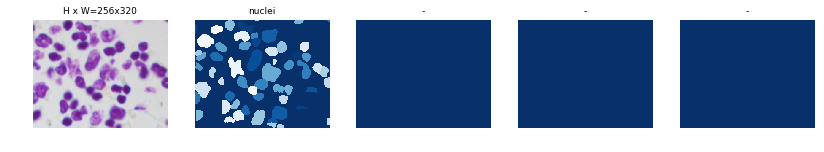

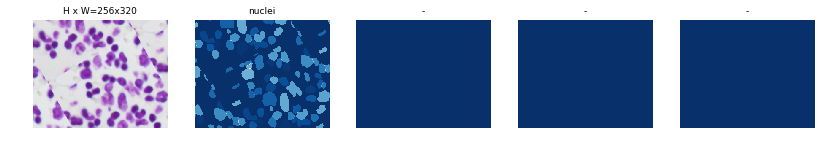

In [20]:
testing_id = 460

# Original image

image = dataset_train.load_image(testing_id)
mask, class_ids = dataset_train.load_mask(testing_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Augmented image
image = dataset_aug.load_image(testing_id)
mask, class_ids = dataset_aug.load_mask(testing_id)
visualize.display_top_masks(image, mask, class_ids, dataset_aug.class_names)

